In [1]:
import csv
import os
from math import log10, inf
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
class Kind(Enum):
    Acc = 'accuracy.csv'
    Mem = 'mem-ideal.csv'
    Perf = 'perf.csv'
    Per_particle = 'per-particles.csv'
    Per_step = 'per-step.csv'
    Per_step_mem = 'per-step-mem.csv'
    Perf_step = 'perf-step.csv'
    
class Algo(Enum):
    # DS = 'ds_nogc'
    # BDS = 'ds_bounded'
    SDS = 'ds'
    PF = 'particles'
    SSDS = 'semi_symb'
    
class Example(Enum):
    BetaBernoulli = 'coin'
    Gaussian = 'gaussian'
    Kalman = 'kalman'
    Outlier = 'outlier'
    Robot = 'tracker'
    Slam = 'slam'
    Mtt = 'mtt'
    Gtree = 'gtree'
    Wheels = 'wheels'
    DelayedGPS = 'trackerdelay'
    
class Data:
    def __init__(self, example, algo, kind):
        self.filename = os.path.join('..', example.value, algo.value, kind.value)
        self.file = None
        
    def __enter__(self):
        self.file = open(self.filename, 'r')
        header = [h.strip() for h in self.file.readline().split(',')]
        return csv.DictReader(self.file, fieldnames=header, quoting=csv.QUOTE_NONNUMERIC)
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.file.close()

In [3]:
def get_baseline(example, algo=Algo.SDS, particles=500):
    with Data(example, algo, Kind.Acc) as accuracy, Data(example, algo, Kind.Perf) as perf:
        acc = next(row['median'] for row in accuracy if row['particles'] == particles)
        perf = next(row['median'] for row in perf if row['particles'] == particles)
        return acc, perf

In [4]:
def get_crossing_point(example, algo, baseline={}):
    b_acc, b_perf = get_baseline(example, **baseline)
    with Data(example, algo, Kind.Acc) as accuracy, Data(example, algo, Kind.Perf) as perf:
            cond = lambda x: abs(log10(x) - log10(b_acc)) <= 0.5
            particles = next(row['particles'] for row in accuracy if cond(row['upper quantile']))
            return next(
                (particles, row['time in ms lower quantile'], row['median'], row['upper quantile'])
                for row in perf if row['particles'] == particles)

In [5]:
def get_results(baseline={}):
    res = {}
    for example in Example:
        res[example.name] = {}
        for algo in Algo:
            try:
                (particles, lower, median, upper) = get_crossing_point(example, algo, baseline)
            except(StopIteration, IOError):
                (particles, lower, median, upper) = (inf, 0, 0, 0)
            res[example.name][algo.name] = {
                'particles': particles,
                'lower': lower,
                'median': median,
                'upper': upper }
    return res

In [6]:
def plot(results): 
    barWidth = 0.25
 
    bars1 = [results[ex.name]['PF']['median'] for ex in Example]
    bars2 = [results[ex.name]['SDS']['median'] for ex in Example]
    bars3 = [results[ex.name]['SSDS']['median'] for ex in Example]
 
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
 
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', alpha=0.75)
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', alpha=0.75)
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', alpha=0.75)
 
    plt.xticks([r + barWidth for r in range(len(bars1))], [ex.name for ex in Example])
    plt.yscale('log')
    plt.xticks(rotation=30)
    
    plt.show()

{'BetaBernoulli': {'PF': 150.0, 'SDS': 1.0, 'SSDS': 1.0},
 'DelayedGPS': {'PF': 150.0, 'SDS': 15.0, 'SSDS': 1.0},
 'Gaussian': {'PF': 3500.0, 'SDS': 150.0, 'SSDS': 150.0},
 'Gtree': {'PF': 150.0, 'SDS': 80.0, 'SSDS': 1.0},
 'Kalman': {'PF': 15.0, 'SDS': 1.0, 'SSDS': 1.0},
 'Mtt': {'PF': 4000.0, 'SDS': 45.0, 'SSDS': 45.0},
 'Outlier': {'PF': 650.0, 'SDS': 65.0, 'SSDS': 60.0},
 'Robot': {'PF': 90.0, 'SDS': 1.0, 'SSDS': 1.0},
 'Slam': {'PF': inf, 'SDS': 900.0, 'SSDS': 900.0},
 'Wheels': {'PF': 450.0, 'SDS': 500.0, 'SSDS': 1.0}}


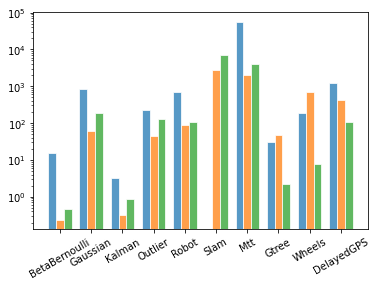

In [7]:
results = get_results({'algo': Algo.SDS, 'particles': 500})
pprint({ex: {algo: results[ex][algo]['particles'] for algo in results[ex]} for ex in results})
plot(results)

In [8]:
# Generate summary table.

def to_latex(baseline):
    exs = {'BetaBernoulli': 'Beta-Bernoulli',
           'Gaussian': 'Gaussian-Gaussian',
           'Kalman': 'Kalman-1D',
           'Outlier': 'Outlier',
           'Robot': 'Robot',
           'Slam': 'SLAM',
           'Slam-2000': 'SLAM-2000',
           'Slam-4000': 'SLAM-4000',
           'Mtt': 'MTT',
           'Mtt-2000': 'MTT-2000',
           'Mtt-4000': 'MTT-4000',
           'Gtree' : 'Tree',
           'Wheels': 'Wheels',
           'DelayedGPS': 'Delayed GPS', }

    results = get_results(baseline)
    for name, ex  in results.items():
        print(exs[name], end=" ")
        for algo in ["PF", "SDS", "SSDS"]:
            results = ex[algo]
            p = results['particles']
            if p < inf:
                if p == 1: fp = "\\exact"
                else: fp = f"{int(p):d}"
            else: fp = " "
                    
            t = results['median']
            if t <= 0.0: ft = "\\timeout"
            else: ft = f"{results['median']:.2f}"
            print(f"& {fp} & {ft}", end=" ")
        print("\\\\")
        
to_latex({'algo': Algo.SDS, 'particles': 1000})


# Print some stats
results = get_results({'algo': Algo.SDS, 'particles': 1000})

sds = np.array([ex['SDS']['median'] for _, ex in results.items()])
ssds = np.array([ex['SSDS']['median'] for _, ex in results.items()])
pf = np.array([ex['PF']['median'] for _, ex in results.items()])


print(f"spedup SSDS PF {np.nanmean(pf / ssds, axis=0)}")
print(f"spedup SDS SSDS {np.nanmean(ssds / sds, axis=0)}")

print(f"tree spedup SDS SSDS {results['Gtree']['SDS']['median']/ results['Gtree']['SSDS']['median']}")
print(f"wheels spedup SDS SSDS {results['Wheels']['SDS']['median']/ results['Wheels']['SSDS']['median']}")
print(f"delayed GPS spedup SDS SSDS {results['DelayedGPS']['SDS']['median']/ results['DelayedGPS']['SSDS']['median']}")

Beta-Bernoulli & 150 & 15.12 & \exact & 0.24 & \exact & 0.47 \\
Gaussian-Gaussian & 3500 & 852.93 & 150 & 61.34 & 150 & 185.84 \\
Kalman-1D & 15 & 3.26 & \exact & 0.33 & \exact & 0.89 \\
Outlier & 650 & 222.32 & 65 & 45.70 & 60 & 127.22 \\
Robot & 90 & 709.76 & \exact & 86.24 & \exact & 108.41 \\
SLAM &   & \timeout & 900 & 2703.93 & 900 & 7146.59 \\
MTT &   & \timeout & 60 & 2813.20 & 60 & 5423.15 \\
Tree & 150 & 31.11 & 80 & 46.31 & \exact & 2.16 \\
Wheels & 550 & 244.36 & 500 & 681.28 & \exact & 7.99 \\
Delayed GPS & 150 & 1245.97 & 15 & 411.17 & \exact & 107.06 \\
spedup SSDS PF 10.566547926538348
spedup SDS SSDS 1.6606827982971797
tree spedup SDS SSDS 21.4794382228324
wheels spedup SDS SSDS 85.25938540584158
delayed GPS spedup SDS SSDS 3.84071649567525


{'BetaBernoulli': {'PF': 150.0, 'SDS': 1.0, 'SSDS': 1.0},
 'DelayedGPS': {'PF': 150.0, 'SDS': 15.0, 'SSDS': 1.0},
 'Gaussian': {'PF': 3500.0, 'SDS': 150.0, 'SSDS': 150.0},
 'Gtree': {'PF': 150.0, 'SDS': 80.0, 'SSDS': 1.0},
 'Kalman': {'PF': 15.0, 'SDS': 1.0, 'SSDS': 1.0},
 'Mtt': {'PF': inf, 'SDS': 60.0, 'SSDS': 60.0},
 'Outlier': {'PF': 650.0, 'SDS': 65.0, 'SSDS': 60.0},
 'Robot': {'PF': 90.0, 'SDS': 1.0, 'SSDS': 1.0},
 'Slam': {'PF': inf, 'SDS': 900.0, 'SSDS': 900.0},
 'Wheels': {'PF': 750.0, 'SDS': 750.0, 'SSDS': 1.0}}


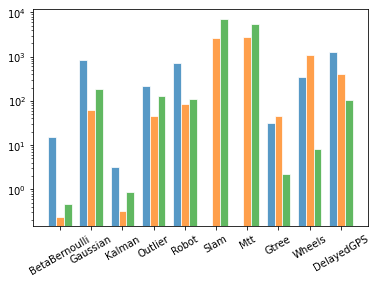

In [9]:
results = get_results({'algo': Algo.SSDS, 'particles': 1000})
pprint({ex: {algo: results[ex][algo]['particles'] for algo in results[ex]} for ex in results})
plot(results)

/var/folders/c8/4hf1pcwd0bz7_m5fnnwxjxkw0000gn/T/ipykernel_20072/125230096.py:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


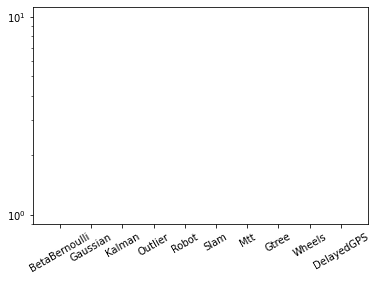

In [10]:
plot(get_results({'algo': Algo.PF, 'particles': 10000}))

In [11]:
# For Figure 10: timeout after 10,000ms if 10x slower than SDS

def get_timeout(example, algo, baseline={}):
    _, _, sds_perf, _ = get_crossing_point(example, Algo.SDS, baseline)
    with Data(example, algo, Kind.Perf) as perf:
        cond = lambda x: x >= sds_perf * 10.
        return next(
            (row['particles'], row['time in ms lower quantile'], row['median'], row['upper quantile'])  
            for row in perf if cond(row['median']))
    
    
def get_results_with_timeout(baseline={}):
    res = {}
    for example in Example:
        res[example.name] = {}
        for algo in Algo:
            try:
                (particles, lower, median, upper) = get_crossing_point(example, algo, baseline)
            except(StopIteration, IOError):
                (particles, lower, median, upper) = (inf, 0, 0, 0)
            try:
                (b_particles, b_lower, b_median, b_upper) = get_timeout(example, algo, baseline)
                if b_particles < particles and b_median > 10000:
                    (particles, lower, median, upper) = (-b_particles, b_lower, b_median, b_upper)
            except(StopIteration, IOError):
                (particles, lower, median, upper) = (0, 0, 0, 0)
            res[example.name][algo.name] = {
                'particles': particles,
                'lower': lower,
                'median': median,
                'upper': upper }
    return res

{'BetaBernoulli': {'PF': 150.0, 'SDS': 1.0, 'SSDS': 1.0},
 'DelayedGPS': {'PF': 150.0, 'SDS': 15.0, 'SSDS': 1.0},
 'Gaussian': {'PF': 3500.0, 'SDS': 150.0, 'SSDS': 150.0},
 'Gtree': {'PF': 0, 'SDS': 80.0, 'SSDS': 1.0},
 'Kalman': {'PF': 15.0, 'SDS': 1.0, 'SSDS': 1.0},
 'Mtt': {'PF': -2000.0, 'SDS': 60.0, 'SSDS': 60.0},
 'Outlier': {'PF': 650.0, 'SDS': 65.0, 'SSDS': 60.0},
 'Robot': {'PF': 90.0, 'SDS': 1.0, 'SSDS': 1.0},
 'Slam': {'PF': 0, 'SDS': 0, 'SSDS': 0},
 'Wheels': {'PF': 0, 'SDS': 0, 'SSDS': 1.0}}


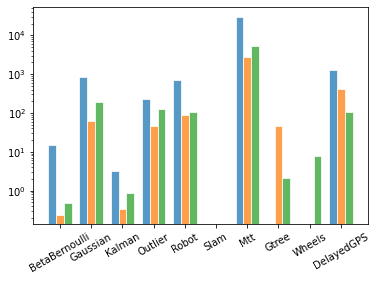

In [12]:
# Result for figure 10.
results_timeout = get_results_with_timeout({'algo': Algo.SDS, 'particles': 1000})
pprint({ex: {algo: results_timeout[ex][algo]['particles'] for algo in results[ex]} for ex in results_timeout})
plot(results_timeout)

In [13]:
def algo_to_pgf(results, algo):
    exs = {'BetaBernoulli': 'Beta-Bernoulli',
           'Gaussian': 'Gaussian-Gaussian',
           'Kalman': 'Kalman-1D',
           'Outlier': 'Outlier',
           'Robot': 'Robot',
           'Slam': 'SLAM',
           'Slam-2000': 'SLAM-2000',
           'Slam-4000': 'SLAM-4000',
           'Mtt': 'MTT',
           'Mtt-2000': 'MTT-2000',
           'Mtt-4000': 'MTT-4000',
           'Gtree' : 'Tree',
           'Wheels': 'Wheels',
           'DelayedGPS': 'Delayed GPS', }
    print("x\ty\ty-min\ty-max\tp")
    for x in results:
        y = results[x][algo.name]['median']
        y_max = results[x][algo.name]['upper'] -  y
        y_min = y - results[x][algo.name]['lower']
        p = int(results[x][algo.name]['particles'])
        if p >= 0:
            print(f"{exs[x]}\t{y}\t{y_min}\t{y_max}\t{p:,d}")
        else:
            print(f"{exs[x]}\t{9900}\t{0.0}\t{0.0}\t{{> {-p:,d}\phantom{{XX}}}}")
        
def to_pgf(results):
    algs = {'PF': '\particles', 'SDS': '\sds', 'SSDS': '\\ssds'}
    for algo in Algo:
        print("\pgfplotstableread{")
        algo_to_pgf(results, algo)
        print(f"}}{{{algs[algo.name]}}}\n")

In [14]:
to_pgf(results_timeout)

\pgfplotstableread{
x	y	y-min	y-max	p
Beta-Bernoulli	0.240918	0.0035530000000000006	0.023206000000000032	1
Gaussian-Gaussian	61.339814	1.9549499999999966	2.805381000000004	150
Kalman-1D	0.326881	0.00037599999999998746	0.006603999999999999	1
Outlier	45.700561	0.3547790000000006	4.103518999999999	65
Robot	86.239659	0.2043639999999982	1.0136889999999994	1
SLAM	0	0	0	0
MTT	2813.198281	250.25719200000003	387.54829199999995	60
Tree	46.309991	0.14275199999999444	1.0378000000000043	80
Wheels	0	0	0	0
Delayed GPS	411.174956	1.0288419999999974	1.6844800000000077	15
}{\sds}

\pgfplotstableread{
x	y	y-min	y-max	p
Beta-Bernoulli	15.11606	0.6425469999999986	0.9354370000000021	150
Gaussian-Gaussian	852.929066	10.043738000000076	27.725201999999967	3,500
Kalman-1D	3.260622	0.0072110000000003005	0.006834999999999702	15
Outlier	222.322823	1.7339800000000025	2.166862000000009	650
Robot	709.757351	1.8667950000000246	2.053568000000041	90
SLAM	0	0	0	0
MTT	9900	0.0	0.0	{> 2,000\phantom{XX}}
Tree	0	0	0	0
Wheels

In [15]:
# Result for figure 11.
pf_2000 = get_results({'algo': Algo.PF, 'particles': 2000})
pf_2000_mtt_slam = {ex+'-2000': pf_2000[ex] for ex in pf_2000 if ex in ['Mtt', 'Slam']}
pf_4000 = get_results({'algo': Algo.PF, 'particles': 4000})
pf_4000_mtt_slam = {ex+'-4000': pf_4000[ex] for ex in pf_4000 if ex in ['Mtt', 'Slam']}
alt_baseline_results = {**pf_2000_mtt_slam, **pf_4000_mtt_slam}
to_pgf(alt_baseline_results)

\pgfplotstableread{
x	y	y-min	y-max	p


OverflowError: cannot convert float infinity to integer